In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pycountry
import statsmodels.api as sm
import warnings
from statsmodels.stats.diagnostic import het_white
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels import IV2SLS
from patsy import dmatrices
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from linearmodels.panel import compare

# Silencing future warnings to remove clutter
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1: API Data Requests

## Data Collection
The data was collected using the World Bank API over a span of 20 years. Indicators were identified through the World Bank Website and descriptions were taken from World Development Indicators (World Bank, 2025) and World Governance Indicators documentation (World Bank, 2024)

# Features
The dataset contains the following indicators:

(i) **GDP Per Capita** : Income per person

(ii) **GDP Growth** : Percentage changes in constant-price GDP per annum

(iii) **Gini Index** : Measure of inequality

(iv) **Trade Openness** : Sum of import and exports as % of GDP

(v) **Education Expenditure** : Government spending as a share of GDP

(vi) **FDI Net Inflows (%GDP)** : Net inflows of foreign investment expressed as a percentage of GDP (World Bank, 2025)

(vii) **Government Effectiveness** : Captures perceptions on governance quality, public services etc.(World Bank, 2024)

(vii) **Regulatory Quality** : Captures perceptions of government ability to implement policies/regulation that promote private sector development. (World Bank, 2025)

# API Method
After an initial failed approach, the *pandas_datareader's* **wb** module was used to loop over the indicators across 20 years over all countries. The following two code blocks demonstrate the initial approach and the successful revised approach.

# Roadblock
The code block below showcases a manual API querying method with manual pagination. Due to constant time-outs and exceptions an alternative approach was pursued using the pandas data reader library.

In [1]:
'''
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    "Gini_Index" : "SI.POV.GINI",
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Reg_Quality" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
}

# Base URL of API requests
base_url = "https://api.worldbank.org/v2/country/all/indicator/{code}?date={year}&format=json&per_page=200&page={page}"

# Important fields here are, format=json and per_page=200. Page will be changed in the function

df_list = []

# Helper function to get the data with indicator and year parameters
def get_worldbank(indicator, year, page=1):
    try:
        url = base_url.format(code=indicator, year=year, page=page)
        response = requests.get(url, timeout=20)
    except:
        print("Exception Raised")
    return response.json()

for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 1)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': ind_name, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Same loop running for page 2 of results
for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 2)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': ind_name, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Creating copy of first dataframe to merge country column later
df_copy = df_list[0][['iso3', 'country']].drop_duplicates()
dfs_final = []

# Iterating over indicators to find duplicate columns due to pagination
for ind in indicators:
    # In each iteration find columns with same indicator
    dfs_dupli = [df for df in df_list if ind in df.columns]
    # Concatenate row-wise
    combined = pd.concat(dfs_dupli, ignore_index=True)
    # Finding duplicate iso3 columns
    iso_cols = [col for col in combined.columns if col.startswith('iso3')]
    # Drop duplicate iso3 columns except the first
    combined = combined.drop(columns=iso_cols[1:])
    # Dropping duplicate iso3
    combined = combined.drop_duplicates(subset=['iso3'])
    # Append new dataframe to list
    dfs_final.append(combined)

# Removing country from every dataframe for a clean merge on iso3
for id, df in enumerate(dfs_final):
    if "country" in df.columns:
        dfs_final[id] = df.drop(columns=['country'])

# Take the first dataframe as the baseline to merge
merged = dfs_final[0]

# Can be seen to be the GDP Per Capita
merged.head()

# Iterating over remaining dataframes and merging on country
for df in dfs_final[1:]:
    # Merging on iso3
    merged = merged.merge(df, on='iso3', how="outer")

# Adding country column back
merged = merged.merge(df_copy, on='iso3', how='left')
# Adding country column to the very left
merged = merged[['country'] + [col for col in merged.columns if col!= 'country']]
# Print missing values
print(merged.isna().sum(), "\n")
# Print Shape
print(merged.shape, "\n")
'''

'\nindicators = {\n    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",\n    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",\n    "Gini_Index" : "SI.POV.GINI",\n    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",\n    "Trade_Openness" : "NE.TRD.GNFS.ZS",\n    "Govt_Effectiveness" : "GE.EST",\n    "Rule_Of_Law" : "RQ.EST",\n    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",\n}\n\n# Base URL of API requests\nbase_url = "https://api.worldbank.org/v2/country/all/indicator/{code}?date={year}&format=json&per_page=200&page={page}"\n\n# Important fields here are, format=json and per_page=200. Page will be changed in the function\n\ndf_list = []\n\n# Helper function to get the data with indicator and year parameters\ndef get_worldbank(indicator, year, page=1):\n    try:\n        url = base_url.format(code=indicator, year=year, page=page)\n        response = requests.get(url, timeout=20)\n    except:\n        print("Exception Raised")\n    return response.json()\n\nfor ind_name, ind_code in indicators.items():\n    print(f"Now pro

# The improved API method
Using the datareader wb module we loop through all indicator to create new dataframes with panel data over a period of 20 years, then merging into a final dataframe. ISO3 country codes were extracted as well to alleviate formatting issues.

In [18]:
from pandas_datareader import wb

# Copying the same indicator dictionary
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    #"Gini_Index" : "SI.POV.GINI",   Gini Index will be taken from an alternative dataset
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Reg_Quality" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
}

# Getting list of ISO3 codes
countries = wb.get_countries()[['name', 'iso3c']]
countries = countries.rename(columns={"name": "Country", "iso3c": "iso3"})

# Empty list for dataframes
df_list = []

# Looping over indicators to download using wb module
for ind_name, ind_code in indicators.items():
    print(f"Processing {ind_name}")

    df = wb.download(
        indicator = ind_code,
        country = 'all',
        start = 2002,
        end = 2022,
    ).reset_index() # Resetting index for merge

    # Renaming columns
    df = df.rename(columns={
        'country' : 'Country', # Upper case
        ind_code : ind_name, # Indicator code to Indicator Name
    })

    # Attaching ISO3s
    df = df.merge(countries, on="Country", how="left")

    # Appending to dataframe list
    df_list.append(df)

# Taking first frame as baseline to merge
panel_wb = df_list[0]

# Looping over dfs, merging each one
for df in df_list[1:]:
    # Dropping country column
    df = df.drop(columns='Country')
    panel_wb = pd.merge(panel_wb, df, on=['iso3', 'year'], how='outer')

# Moving ISO3 to the very left
cols = panel_wb.columns.to_list()
cols = ['iso3'] + [c for c in cols if c != 'iso3']
panel_wb = panel_wb[cols]

Processing GDP_Per_Capita
Processing GDP_Growth
Processing Education_Exp
Processing Trade_Openness
Processing Govt_Effectiveness
Processing Reg_Quality
Processing FDI_Net_Inflows


# Step 2: Data Cleaning and Preparation

# Overview
In the following sections we will proceed with the necessary steps to clean and prepare the dataset for further analysis. Firstly rows with invalid country names will be dropped. We will then extract the Gini Index variable from an alternative dataset and merge our two dataframes together. Lastly, we will fill in a large portion of the missing values in the dataset using linear interpolation, taking care not to remove too much of the variables' natural variation.

# 2.1 Invalid Rows
Going through the dataset it can be seen how some panels are of regional data or other miscellaneous categories. We can drop them using the pycountry library. The library has a list of all ISO3 country codes which we extract as a set, for uniqueness. We filter the original dataset on the valid iso3 codes and then drop rows which are of invalid country codes.

In [19]:
# Getting ISO3 country codes from pycountry
# Creating set of all country iso3 codes from pycountry
iso3_correct = {c.alpha_3 for c in pycountry.countries}

# Rows before
before = panel_wb.shape[0]

# Filtering based on set and creating new frame
panel_wb_clean = panel_wb[panel_wb['iso3'].isin(iso3_correct)].copy()

#Reseting index
panel_wb_clean.reset_index(drop=True, inplace=True)

# Rows after
after = panel_wb_clean.shape[0]

# Printing how many rows we're dropping
print(f"We dropped {before-after} rows\n")

# Checking for empty country name rows
print(f"We are missing {panel_wb_clean['Country'].isna().sum()} country names")

We dropped 3717 rows

We are missing 0 country names


# 2.2 Gini Index Extraction
Gini coverage from the API is sparse. SWIID offers wider global coverage and will be merged into dataframe. Data source: https://fsolt.org/swiid/ https://dataverse.harvard.edu/file.xhtml?fileId=10797566&version=14.0

In [20]:
import zipfile, io
url = "https://dataverse.harvard.edu/api/access/datafile/10797566"

# Requesting the file, it is a zip
r = requests.get(url)
# Downloading bytes of the zip, turn bytes into file object and treat it as ZIP archive
z = zipfile.ZipFile(io.BytesIO(r.content))

# Finding the right file, it is swiid9_8/swiid9_8_summary.csv
print(z.namelist())

csv_name =  "swiid9_8/swiid9_8_summary.csv"
# Reading into pandas
swiid = pd.read_csv(z.open(csv_name))


['swiid9_8/', 'swiid9_8/swiid9_8.rda', 'swiid9_8/stata_swiid.pdf', 'swiid9_8/R_swiid.pdf', 'swiid9_8/swiid9_8_summary.csv', 'swiid9_8/swiid9_8.dta']


# Merging the two datasets

## Creating the ISO3 column
After standardizing ISO3 codes using the pycountry library and filter out naming differences, we merge on ISO3 and year. Some countries that were missing due to naming differences were added to an inclusion dictionary, with their ISO3s being found online from: https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes

In [21]:
# Creating sets from the two country columns
swiid_set = set(swiid['country'].unique())
wb_set = set(panel_wb_clean['Country'].unique())

# Finding set difference
set_diff = swiid_set - wb_set
print("In SWIID but not in merged dataframe")
print(set_diff)
print(f"Missing {len(set_diff)} countries\n")

# Creating iso3 getter helper function
def get_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3     #alpha_3 gives ISO3
    except:
        return None

# Creating iso3 column for swiid to merge
swiid['iso3'] = swiid['country'].apply(get_iso3)

# Seeing if we are missing
print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

# Dropping countries that no longer exist
defunct_countries = ['Czechoslovakia', 'Yugoslavia', 'Soviet Union']
swiid = swiid[~swiid['country'].isin(defunct_countries)]

# Creating dictionary of missing values due to different formatting
iso_swiid_dict = {
    "Egypt": "EGY",
    "Micronesia": "FSM",
    "Venezuela": "VEN",
    "St. Vincent and Grenadines": "VCT",
    "Palestinian Territories": "PSE",
    # Democratic Republic
    "Congo-Kinshasa": "COD",
    "Anguilla": "AIA",
    "Turkey": "TUR",
    "Iran": "IRN",
    "Laos": "LAO",
    "Kyrgyzstan": "KGZ",
    "Cape Verde": "CPV",
    "Vietnam": "VNM",
    "Côte d'Ivoire": "CIV",
    "Tanzania": "TZA",
    "Kosovo": "XKX",
    # Republic
    "Congo-Brazzaville": "COG",
    "Czech Republic": "CZE",
    "Russia": "RUS",
    "Gambia": "GMB",
    "Korea": 'KOR',
    "Taiwan": "TWN",
    "Hong Kong": "HKG",
    "Bahamas": "BHS",
    "São Tomé and Príncipe": "STP",
    "St. Lucia": "LCA",
    "Brunei": "BRN",
    "St. Kitts and Nevis": "KNA",
    "Syria": "SYR"
}

# Mapping dictionary to missing iso3 values
swiid['iso3'] = swiid['iso3'].fillna(
    swiid['country'].map(iso_swiid_dict)
)

# Checking for missing ISOs
print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

In SWIID but not in merged dataframe
{'Vietnam', 'Hong Kong', 'Russia', 'Somalia', 'Puerto Rico', 'St. Vincent and Grenadines', 'Czechoslovakia', 'Micronesia', 'Yugoslavia', 'Kosovo', "Côte d'Ivoire", 'Slovakia', 'Brunei', 'Syria', 'Iran', 'Yemen', 'Gambia', 'Soviet Union', 'Laos', 'Congo-Kinshasa', 'Czech Republic', 'Turkey', 'Kyrgyzstan', 'Palestinian Territories', 'Anguilla', 'Taiwan', 'Korea', 'Bahamas', 'Cape Verde', 'Egypt', 'Congo-Brazzaville', 'São Tomé and Príncipe', 'Venezuela'}
Missing 33 countries

341 missing ISO3s

0 missing ISO3s



## Merging on Year and ISO3
Firstly we check if the two dataframes have the same data type for year. Our panel dataframe doesn't, we change it so we can merge. We can then extract the columns we need from SWIID: ISO3, Year and Gini. We then merge the two dataframes on ISO3 and Year.

In [22]:
print(swiid.info(),'\n')
print(panel_wb_clean.info(), '\n')

# Changing datatype of year to integer
panel_wb_clean['year'] = panel_wb_clean['year'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 6344 entries, 0 to 6397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6344 non-null   object 
 1   year          6344 non-null   int64  
 2   gini_disp     6344 non-null   float64
 3   gini_disp_se  6344 non-null   float64
 4   gini_mkt      6344 non-null   float64
 5   gini_mkt_se   6344 non-null   float64
 6   abs_red       2685 non-null   float64
 7   abs_red_se    2685 non-null   float64
 8   rel_red       2685 non-null   float64
 9   rel_red_se    2685 non-null   float64
 10  iso3          6344 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 594.8+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   iso3                4515 non-null   object 
 1   Country  

In [23]:
# Extracting just iso3, gini column and year
swiid_gini = swiid[['iso3', 'year', 'gini_disp']].copy()

# Merging dataset on year and iso3 (if condition for replicability)
if "Gini_Index" not in panel_wb_clean.columns:
    panel_wb_clean = panel_wb_clean.merge(swiid_gini, on=['iso3','year'], how='left')
    # Renaming column to Gini_Index
    panel_wb_clean = panel_wb_clean.rename(columns={'gini_disp' : 'Gini_Index'})

# Displaying missing Gini rows
print(f"{panel_wb_clean['Gini_Index'].isna().sum()} missing Gini values")

1305 missing Gini values


# 2.3 Imputation (for Regressions)

## Linear Interpolation
We will use linear interpolation to impute the values since it maintains within-country variation. To fine-tune the imputation we calculate persistence scores, the correlation of a variable with its lagged value, to find which variables are most appropriate for "smoothing". All columns with high persistence will have all their values interpolated, less the edge cases that interpolation fails to impute. Intermediate and low persistence will face a limit on consecutive missing rows to not overly smooth the data.

In [26]:
# Creating copy of raw dataframe
panel_wb_imputed = panel_wb_clean.copy()

# Creating helper function for calculating persistence
def var_persistence(df, var):
    # Making sure the years and countries are sorted
    df = df.sort_values(['iso3', 'year'])

    # Creating a lagged variable column
    df[f"{var}_Lag1"] = df.groupby("iso3")[var].shift(1)

    # Calculating correlation and extracting value from matrix
    corr = df[[var,f"{var}_Lag1"]].corr().iloc[0, 1]

    # Returning correlation
    return corr

# Creating list of numeric columns
numeric_cols = panel_wb_imputed.select_dtypes(include='number').columns.to_list()

# Dropping year column from list
numeric_cols.remove('year')

# Looping over columns to see persistence and adding column names to list based on persistence
for col in numeric_cols:
    pers = var_persistence(panel_wb_imputed, col)
    print(f"Persistence: {col} : {pers}\n")
    # Checking for high persistence (0.85) and applying interpolation to all rows
    if pers > 0.85:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit_direction='both'))
    # Checking for intermediate persistence (0.5) and applying interpolation to up to 3 consecutive missing rows
    elif pers > 0.5:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=3, limit_direction='both'))
    # Otherwise the persistence is weak and only interpolate up to 1 consecutive missing row
    else:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=1, limit_direction='both'))

Persistence: GDP_Per_Capita : 0.9922677449132742

Persistence: GDP_Growth : 0.16842811933395918

Persistence: Education_Exp : 0.9320056635588188

Persistence: Trade_Openness : 0.9633594025337419

Persistence: Govt_Effectiveness : 0.990598337558557

Persistence: Reg_Quality : 0.991733392709829

Persistence: FDI_Net_Inflows : 0.5900266147622736

Persistence: Gini_Index : 0.9991886574691943



In [28]:
# Finding total sum of sums of missing values on raw dataset
before_missing = sum(panel_wb_clean.isna().sum())
# Finding total sum of sums of missing values on processed dataset
after_missing = sum(panel_wb_imputed.isna().sum())

print(f"We have filled in {before_missing - after_missing} values\n")

# Checking which are still missing
panel_wb_imputed.isna().sum()

We have filled in 2559 values



iso3                    0
Country                 0
year                    0
GDP_Per_Capita         63
GDP_Growth            167
Education_Exp         336
Trade_Openness        483
Govt_Effectiveness    231
Reg_Quality           231
FDI_Net_Inflows       412
Gini_Index            525
dtype: int64

# 2.4 Saving The Cleaned Dataframes
Having cleaned our data and performed the necessary pre-processing steps we will save the raw cleaned version along with the imputed cleaned version for further analysis.

In [29]:
# Saving raw dataset
panel_wb_clean.to_csv("wb_raw.csv", index=False)

# Saving imputed dataset
panel_wb_imputed.to_csv("wb_imputed.csv", index=False)

# Section 3: Exploratory Analysis
We will calculate descriptive statistics, ranges, variances and standard deviations of each column

## 3.1 Descriptive Statistics
+ Can identify outliers, skewness and type of distributions
+ If mean is higher than the median it is right-skewed (e.g. GDP per capita) and vice-versa for left-skewness
+ Ranges, mean and standard deviation can inform us on the type of distribution (e.g. Govt. Effectiveness is approximately normal; almost 0 mean, same absolute min/max value, std dev of approximately 1)
+ Extreme outliers have economic interpretations, e.g. GDP Growth of -54% hints towards a depression, and may require log transformations

In [30]:
# Importing raw dataset
wb_raw = pd.read_csv("wb_raw.csv")

# Importing imputed dataset
wb_imputed = pd.read_csv("wb_imputed.csv")

# Excluding year column from analysis
wb_stat = wb_raw.copy()
wb_stat.drop(columns='year', inplace=True)

# Descriptive statistics
print("--------Descriptive Stats--------")
print(f"{wb_stat.describe()}\n")

--------Descriptive Stats--------
       GDP_Per_Capita   GDP_Growth  Education_Exp  Trade_Openness  \
count     4386.000000  4330.000000    2976.000000     3777.000000   
mean     16343.139799     3.325970       4.386914       91.125718   
std      25082.645980     6.009641       1.971352       59.278484   
min        109.593814   -54.336106       0.000004        2.698834   
25%       1649.323704     1.169075       3.071372       55.784126   
50%       5656.586863     3.537641       4.199421       78.814980   
75%      21303.481866     5.997803       5.372008      108.869117   
max     226052.001905    91.137039      16.230376      863.195099   

       Govt_Effectiveness  Reg_Quality  FDI_Net_Inflows   Gini_Index  
count         4199.000000  4199.000000      4036.000000  3210.000000  
mean            -0.028098    -0.028528         9.442848    38.649533  
std              0.996390     0.996695        64.892966     7.923534  
min             -2.440229    -2.547726     -1303.108267    2

## 3.2 Ranges, Variances and Standard Deviations
+ GDP Per Capita has highest range. It is to be expected since it is a level dollar amount
+ Govt Effectiveness and Regulatory Quality have lowest ranges, they're approximately normal
+ GDP Per Capita, Trade Openness and FDI Net Inflows have high standard, they may require log transformation for normality.

In [53]:
# Finding range of each value
range_df = wb_stat.max(numeric_only=True) - wb_stat.min(numeric_only=True)
print("--------Ranges--------")
print(f"{range_df}\n")

# Variance and Standard Deviations
print("--------Variance--------")
print(f"{wb_stat.var(numeric_only=True)}\n")
print("--------Standard Deviations--------")
print(f"{wb_stat.std(numeric_only=True)}\n")

--------Ranges--------
GDP_Per_Capita        225942.408092
GDP_Growth               145.473145
Education_Exp             16.230372
Trade_Openness           860.496265
Govt_Effectiveness         4.909889
Rule_Of_Law                4.799961
FDI_Net_Inflows         3012.935499
Gini_Index                42.700000
dtype: float64

--------Variance--------
GDP_Per_Capita        6.291391e+08
GDP_Growth            3.611579e+01
Education_Exp         3.886229e+00
Trade_Openness        3.513939e+03
Govt_Effectiveness    9.927937e-01
Rule_Of_Law           9.934014e-01
FDI_Net_Inflows       4.211097e+03
Gini_Index            6.278239e+01
dtype: float64

--------Standard Deviations--------
GDP_Per_Capita        25082.645980
GDP_Growth                6.009641
Education_Exp             1.971352
Trade_Openness           59.278484
Govt_Effectiveness        0.996390
Rule_Of_Law               0.996695
FDI_Net_Inflows          64.892966
Gini_Index                7.923534
dtype: float64



## 3.3 Correlations
A correlation matrix will be designed to find interesting relationships and multicolinearities within our variables. If two variables are highly colinear they must not be regressed together as it will harm the precision of the estimator.

In [31]:
# Selecting all numeric columns
num = wb_raw[[col for col in wb_stat.columns if col != "Country"
              and col !="year" and col != 'iso3']]

# Correlation Matrix
corr = wb_stat.corr(numeric_only=True)
print(corr, "\n")

# Finding highly correlated variables to avoid multicolinearity in regressions later on

# Creating empty list of corr values to check for duplicates
corr_values = []

# Looping over columns to find correlations which exceed threshold
for col1 in num.columns:
    for col2 in num.columns:
        if col1 != col2:
            corr_value = corr.loc[col1, col2]
            # Cutoff is set at 0.7, absolute value for both negative and positive correlation
            if abs(corr_value) > 0.7 and corr_value not in corr_values:
                print(f"{col1} with {col2}: {abs(corr_value)}")
                corr_values.append(corr_value)

                    GDP_Per_Capita  GDP_Growth  Education_Exp  Trade_Openness  \
GDP_Per_Capita            1.000000   -0.080560       0.031910        0.331867   
GDP_Growth               -0.080560    1.000000      -0.114820        0.015903   
Education_Exp             0.031910   -0.114820       1.000000        0.067384   
Trade_Openness            0.331867    0.015903       0.067384        1.000000   
Govt_Effectiveness        0.700918   -0.105384       0.246728        0.366019   
Reg_Quality               0.664790   -0.109726       0.153606        0.343844   
FDI_Net_Inflows           0.245313    0.000170      -0.022534        0.200137   
Gini_Index               -0.496290    0.085503      -0.165906       -0.249229   

                    Govt_Effectiveness  Reg_Quality  FDI_Net_Inflows  \
GDP_Per_Capita                0.700918     0.664790         0.245313   
GDP_Growth                   -0.105384    -0.109726         0.000170   
Education_Exp                 0.246728     0.153606   

GDP Per Capita and Govt Effectiveness were found to be highly correlated and must not be regressed together. Government Effectiveness and Regulatory Quality were also found to be very highly correlated and must be substituted for one another, never regressed together.

# 3.4 Histograms

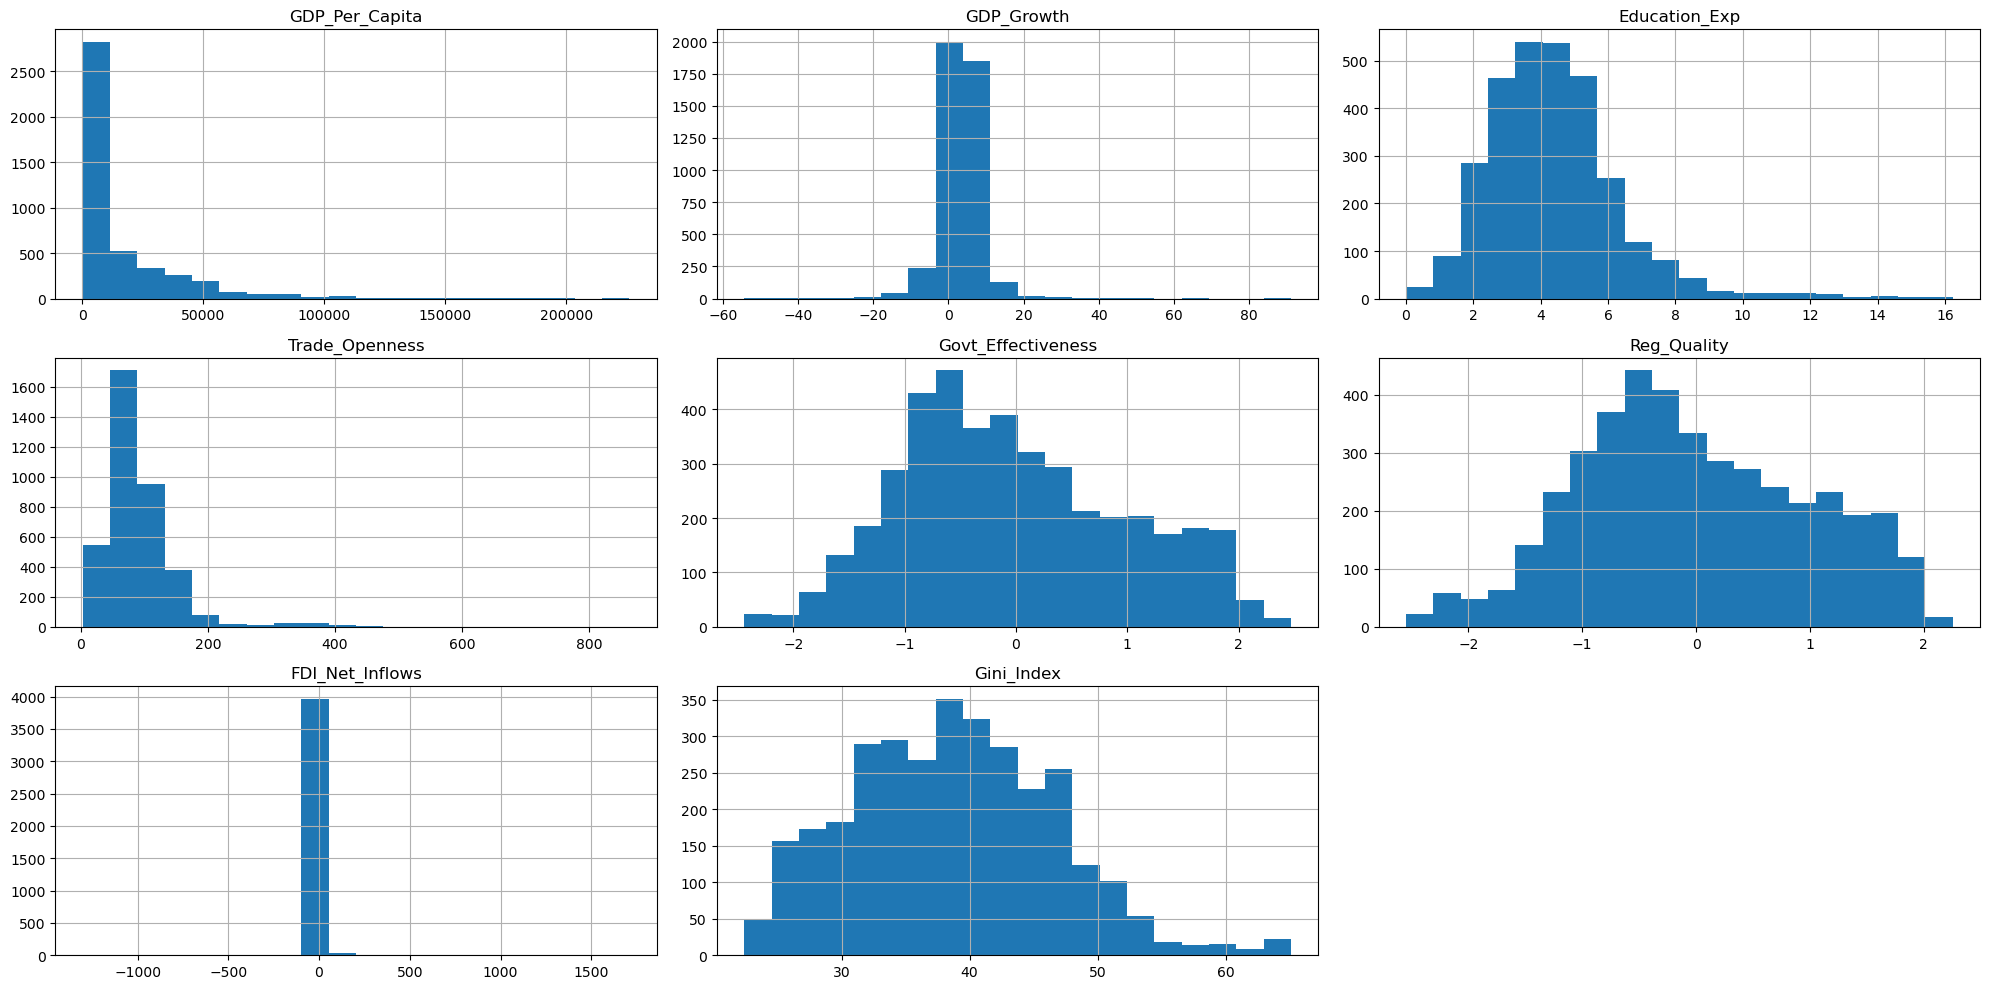

In [32]:
# Histograms

num.hist(figsize=(20, 10), bins=20)
plt.tight_layout()
plt.show()

## Interpretation of Histograms and Transformation Implications
We can observe that GDP Per Capita, Trade Openness, Education Expenditure and particularly FDI Inflows are heavily skewed. To make the distribution more symmetrical and reduce the influence of extreme outliers we can logarithmically transform these columns.

# 3.5 Feature Engineering

## Log transformations
GDP per capita, Trade Openness, Education Expenditure and FDI Inflows will be logarithmically transformed to alleviate the issues of skewness and extreme outliers. Since FDI has negative values we transform with the inverse hyperbolic sine function:
$$
\operatorname{asinh}(x) = \ln\left(x + \sqrt{x^{2} + 1}\right)
$$
## Gini
We will create a new non-linear term, Gini Squared, which is a squared transformation of the Gini Index. This is in line with the Kuznets hypothesis of a U-shaped degree of inequality.

# Interaction Terms
The interaction terms are founded on some common assumptions:

### Log Education Expenditure with Government Effectiveness
We assume more spending on education means the government is more effective and vice-versa

### Log of GDP per Capita with Regulatory Quality
We assume countries with greater regulatory quality have greater GDP per capita and vice-versa

### Log of Trade Openness with Regulatory Quality
We assume more open economies have greater regulatory quality and vice-versa


In [35]:
# Sign Log Transforming FDI_Net_Inflows
# Applying arcinsh function - manual approach np.log(fdi + (np.sqrt(fdi**2 + 1)))
wb_raw["FDI_Log"] = np.arcsinh(wb_raw['FDI_Net_Inflows'])

# Log Transformations of skewed features
wb_raw["GDP_Pc_Log"] = np.log(wb_raw["GDP_Per_Capita"])
wb_raw["Trade_Log"] = np.log(wb_raw["Trade_Openness"])
wb_raw['Educ_Log'] = np.log(wb_raw['Education_Exp'])

# Polynomial feature
wb_raw['Gini_Sq'] = wb_raw["Gini_Index"]**2

# Interaction Terms
wb_raw["Educ_Govt_Eff"] = wb_raw["Educ_Log"] * wb_raw["Govt_Effectiveness"]
wb_raw["GDP_RegQ"] = wb_raw["GDP_Pc_Log"] * wb_raw["Reg_Quality"]
wb_raw['Trade_RegQ'] = wb_raw['Trade_Log'] * wb_raw['Reg_Quality']

# Performing the same transformations on imputed df
wb_imputed["FDI_Log"] = np.arcsinh(wb_imputed['FDI_Net_Inflows'])
wb_imputed["GDP_Pc_Log"] = np.log(wb_imputed["GDP_Per_Capita"])
wb_imputed["Trade_Log"] = np.log(wb_imputed["Trade_Openness"])
wb_imputed['Educ_Log'] = np.log(wb_imputed['Education_Exp'])
wb_imputed['Gini_Sq'] = wb_imputed["Gini_Index"]**2
wb_imputed["Educ_Govt_Eff"] = wb_imputed["Educ_Log"] * wb_imputed["Govt_Effectiveness"]
wb_imputed["GDP_RegQ"] = wb_imputed["GDP_Pc_Log"] * wb_imputed["Reg_Quality"]
wb_imputed['Trade_RegQ'] = wb_imputed['Trade_Log'] * wb_imputed['Reg_Quality']


# 3.6 Scatterplot of Gini with GDP Growth
We plot Gini with GDP Growth to observe if there is a non-linear relationship between them. This will help us justify the polynomial term's inclusion. We define an outlier trimming function to make our data better suited for graphs, as the axes won't be distorted.

In [36]:
# Creating outlier trimming helper function
def trim_out(df, cols, lower_bound=0.01, upper_bound=0.99):

    df_trim = df.copy()

    for col in cols:
        # Calculating lower quartile
        low = df_trim[col].quantile(lower_bound)
        # Calculating upper quartile
        high = df_trim[col].quantile(upper_bound)
        # Filtering dataset
        df_trim = df_trim[(df_trim[col] >= low) & (df_trim[col] <= high)]
    return df_trim

# Calculating averaged dataframe for plotting
We will calculate the averages on the imputed dataframe to plot the Gini values as a cross-section. The year range is [2015-2019]. This dataframe will be reused for regression.

In [37]:
# Creating a copy of imputed dataset with year range filter
wb_15to19 = wb_imputed[wb_imputed['year'].between(2015,2019)].copy()

# Creating list of columns to average - these are the variables in first regression later on
vars_avg = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log',
        'Govt_Effectiveness', 'Educ_Govt_Eff']

# Grouping by ISO and Country and taking the mean
wb_avg = wb_15to19.groupby(['iso3', 'Country'])[vars_avg].mean()

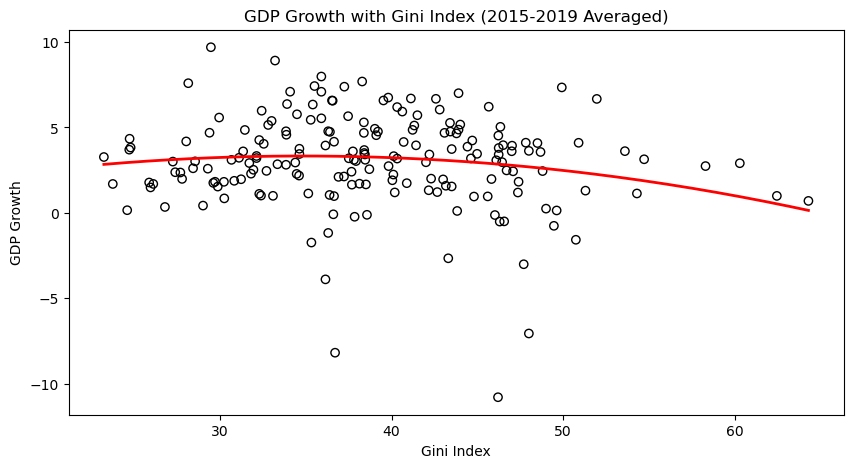

In [38]:
# Dropping missing values
wb_plot = wb_avg.dropna(subset=['GDP_Growth', 'Gini_Index'])

# Defining x and y
x = wb_plot['Gini_Index'].values
y = wb_plot['GDP_Growth'].values

# Fitting quadratic polynomial line
coef = np.polyfit(x, y, deg=2)
poly = np.poly1d(coef)

# Generate curve line
x_curve = np.linspace(x.min(), x.max(), 200)
y_curve = poly(x_curve)

# Defining plot and size
plt.figure(figsize=(10,5))

# Defining scatter
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='k')

# Plotting quadratic curve
plt.plot(x_curve, y_curve, color="red", linewidth=2)

# Labels
plt.xlabel('Gini Index')
plt.ylabel('GDP Growth')

# Title
plt.title('GDP Growth with Gini Index (2015-2019 Averaged)')

plt.show()

# Implications of the graph
We can see a weak non-linear relationship which resembles an inverted U-shape, so there is both theoretical and now empirical support for including the non-linear term.

# Section 4: Economic Analysis
## 1. Do more unequal income distributions affect an economy's growth?
We define the equation as:

$$
\begin{aligned}
\overline{\text{GDP\_Growth}}_{i}
&= \beta_0
+ \beta_1 \,\overline{\text{Gini}}_{i}
+ \beta_2 \,\overline{\text{Gini}}^{\,2}_{i}
+ \beta_3 \log(\overline{\text{GDP\_Pc}}_{i})
+ \beta_4 \log(\overline{\text{Educ\_Exp}}_{i}) \\
&\quad
+ \beta_5 \log(\overline{\text{Trade}}_{i})
+ \beta_6 \,\overline{\text{Govt\_Effectiveness}}_{i}
+ \beta_7 \left(\overline{\text{Educ\_Exp}}_{i} \times \overline{\text{Govt\_Effectiveness}}_{i}\right)
+ \text{ε}_{i}
\end{aligned}
$$

Our dependent variable here is GDP growth and the main explanatory variables are Gini and Gini squared. Here we aim to find the **between** country effect, we define a time period [2015-2019] and take the average of all variables over this period. This fixed the time variable and turns the panel into a cross-section.

In [39]:
# Statistical significance helper function
def stat_significance(est):
    p_values = est.pvalues
    for feature, p in p_values.items():
        if p <= 0.01:
            print(f"{feature}: {p} -- Reject at 1% significance level\n")
        elif p <= 0.05:
            print(f"{feature}: {p} -- Reject at 5% significance level\n")
        elif p<= 0.1:
            print(f"{feature}: {p} -- Reject at 10% significance level\n")
        else:
            print(f"{feature}: {p} -- Fail to reject at 10% significance level\n")


In [40]:
# Question 1

# Setting up formula
formula_1 = (""
           "GDP_Growth ~ Gini_Index + Gini_Sq + "
           "GDP_Pc_Log + Educ_Log + Trade_Log + "
             "Govt_Effectiveness + Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_1 = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log', 'Govt_Effectiveness']

# Rows before
before = wb_avg.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q1 = wb_avg.dropna(subset=vars_1)

# Rows after
after = wb_q1.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_1, data=wb_q1, return_type='dataframe')

# Defining OLS model
model_1 = sm.OLS(y, X)

# Estimating
estimate_1 = model_1.fit()

print(estimate_1.summary())

stat_significance(estimate_1)

We dropped 20.93% rows
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.870
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           3.16e-09
Time:                        13:47:49   Log-Likelihood:                -376.89
No. Observations:                 170   AIC:                             769.8
Df Residuals:                     162   BIC:                             794.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

# Summary Table Interpretation
Our two coefficients of interest are 0.2138 and -0.0029. If we partial them out they form the equation:
$$
\begin{aligned}
\frac{\partial\, \widehat{\text{GDP\_Growth}}}{\partial\, \text{Gini}}
&= \beta_{1} + 2\beta_{2}\,\text{Gini} \\
&= 0.214 + 2(-0.00289)\,\text{Gini}
\end{aligned}
$$
So we have a constant and a decreasing term in Gini, meaning it is a concave function. We can find its turning point by setting the partial derivative to 0.
$$
\begin{aligned}
0.214 + 2(-0.00289)\,\text{Gini} = 0 \\
\text{Gini} = 37.04
\end{aligned}
$$
We have here GDP Growth increasing in Gini at a decreasing rate, until its turning point, after which it starts decreasing. We can interpret this as: (i) in very equal societies increasing inequality can increase GDP Growth, (ii) in less equal societies increasing inequality can increase GDP Growth by less, (iii) at the turning point, every subsequent increase will lead to lower growth.

Of note here is that the two variables are not statistically significant at 10% significance level. We will explore why.

# 1a. Is the inference reliable?
The inference may not be reliable if the residuals are heteroskedastic. To test for heteroskedasticity we run White's test and extract the LM and F-test P-values. We confidently reject the null of homoskedasticity at a 0.01% level of significance. Having concluded the errors are heteroskedastic we fit the model again with robust standard errors.

In [41]:
## Testing for heteroskedasticity

# White's test
lm_stat, lm_p, f_stat, f_p = het_white(estimate_1.resid, X)

print(f"White LM P-value: {lm_p}")
print(f"White F-test P-value: {f_p}")
# We reject the null of homoskedasticity at all levels of significance

# Estimating with robust standard errors
estimate_robust = model_1.fit(cov_type='HC1')

# Comparing robust results with homoskedastic in a dataframe
comparative_df = pd.DataFrame({
    "Coeff" : estimate_1.params,
    "SE_Homoskedastic" : estimate_1.bse,
    "SE_Robust" : estimate_robust.bse,
    "t_Homoskedastic" : estimate_1.tvalues,
    "t_Robust" : estimate_robust.tvalues,
    "p_Homoskedastic" : estimate_1.pvalues,
    "p_Robust" : estimate_robust.pvalues
})
# Applying map to format all values to 3sf on every column
for col in comparative_df.columns:
    comparative_df[col] = comparative_df[col].map('{:.3g}'.format)
comparative_df

White LM P-value: 9.193359556985656e-09
White F-test P-value: 1.243616099995026e-14


,Coeff,SE_Homoskedastic,SE_Robust,t_Homoskedastic,t_Robust,p_Homoskedastic,p_Robust
Intercept,13.7,5.11,5.12,2.67,2.67,0.00833,0.00762
Gini_Index,0.214,0.18,0.141,1.18,1.52,0.238,0.129
Gini_Sq,-0.00288,0.00215,0.00159,-1.34,-1.82,0.182,0.0693
GDP_Pc_Log,-1.77,0.258,0.296,-6.85,-5.98,1.42e-10,2.17e-09
Educ_Log,-1.2,0.519,0.491,-2.32,-2.44,0.0218,0.0145
Trade_Log,0.656,0.367,0.387,1.79,1.69,0.0759,0.0902
Govt_Effectiveness,2.99,0.55,0.782,5.44,3.82,1.97e-07,0.000132
Educ_Govt_Eff,-0.375,0.239,0.215,-1.57,-1.74,0.119,0.0815


We can see in the dataframe how the coefficients don't change but their standard errors and associated inference test statistics do. Standard errors for some variables like Trade_Log rise, meaning their corresponding t-statistic falls. With robust standard errors we are less certain about these estimates, they are less statistically significant. Conversely,some variables like Gini have a lower standard error so they become more statistically significant in the model.

# 1b. Does inequality and its non-linear transformation jointly influence growth?
We are here testing the joint hypothesis that the coefficients of Gini and Gini Squared are significantly different form 0, either of them or both. The null hypothesis is that **both** of their coefficients are not statistically significant from 0. The alternative is that **at least** one of their coefficients, or both, are statistically significant.
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}} = 0 \ \text{and}\ \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}} \neq 0 \ \text{or}\ \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [42]:
F_results = estimate_robust.f_test("Gini_Index = 0, Gini_Sq = 0")
print(F_results)

<F test: F=3.0463429127964865, p=0.05026457803442638, df_denom=162, df_num=2>


We reject the null at 10% significance level that both coefficients for Gini and Gini squared are significantly different from 0. There is some evidence that Gini and its non-linear transformation jointly affect growth

# 1c. Is inequality's effect on GDP Growth non-linear?
We want to test the hypothesis that the coefficient on Gini squared is significantly different from 0:
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [43]:
t_results = estimate_robust.t_test("Gini_Sq = 0")
print(t_results)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0029      0.002     -1.817      0.069      -0.006       0.000


We can reject the null at 10% confidence level. There is evidence that the effect of Gini on Growth is non-linear. Based on the magnitude of the coefficient however it is marginal.

# 1d. Why were inference tests in our summary table unreliable?
This is because Gini and Gini squared are almost perfectly colinear. The OLS estimator was imprecise, the standard errors were exceptionally high which led to unreliable inference. When we took a joint F-test we were looking at the joint effect they had on growth, so their variation combined was used to explain the variation in the dependent variable. This approach did not need to distinguish between which of the two variables was having which effect, which couldn't be done individually since they were close to perfect correlation. We calculate the correlation of the two variables in the next code cell and see it is 0.99, almost perfect correlation.

In [44]:
corr_gini = wb_q1['Gini_Index'].corr(wb_q1['Gini_Sq'])
print(corr_gini)

0.9905074992627813


## 2. Does greater international trade integration **within a country** lead to higher FDI inflows?
We define:
$$
\begin{aligned}
\log(\text{FDI}_it)
&= \beta_0
+ \beta_1 \log(\text{Trade}_{it})
+ \beta_2 \log(\text{GDP\_Pc}_{it})
+ \beta_3 \,\text{Gini}_{it}
+ \beta_4 \,\text{Gini}^2_{it}
+ \beta_5 \,\text{Reg\_Quality}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Reg\_Quality}_{it} \times \log(\text{GDP\_Pc}_{it}) \right)
+ \beta_7 \left( \log(\text{Trade}_{it}) \times \text{Reg\_Quality}_{it} \right)
+  \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$

Here we aim to estimate the **within** country effect, so fixed effects will be used. We will control for country and time fixed effects, so the constant will vary over time. Our explained variable is the log of FDI inflows and our main explanatory variable is the log of Trade openness.

In [45]:
# Question 2

# Setting up formula
formula_2 = (""
           "FDI_Log ~ Trade_Log + GDP_Pc_Log + "
           "Gini_Index + Gini_Sq + Reg_Quality + "
             "GDP_RegQ + Trade_RegQ"
             )

# List of variables on which to drop rows (interaction excluded)
vars_2 = ['FDI_Log', 'Trade_Log', 'GDP_Pc_Log',
        'Gini_Index', 'Gini_Sq', 'Reg_Quality',
          'GDP_RegQ', 'Trade_RegQ']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q2 = wb_imputed.dropna(subset=vars_2)

# Setting multi-index
wb_q2 = wb_q2.set_index(['iso3', 'year'])

# Rows after dropping missing values
after = wb_q2.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_2, data=wb_q2, return_type='dataframe')

# Defining OLS model
model_2 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_2 = model_2.fit(cov_type='clustered', cluster_entity=False)

print(estimate_2.summary)

stat_significance(estimate_2)

We dropped 20.69% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:                FDI_Log   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.0832
No. Observations:                3581   R-squared (Within):               0.0241
Date:                Wed, Nov 26 2025   R-squared (Overall):              0.0448
Time:                        13:48:26   Log-likelihood                   -5094.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.7780
Entities:                         174   P-value                           0.0000
Avg Obs:                       20.580   Distribution:                  F(7,3380)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.4039
     

# Summary Table Interpretation

# 2a. What is the interpretation of the fixed effect constants?


In [46]:
# Extracting fixed effects
effects_est = estimate_2.estimated_effects

# Printing first few rows
print(effects_est.head(20))

           estimated_effects
iso3 year                   
AFG  2002          -0.656935
     2003          -0.641077
     2004          -0.466811
     2005          -0.336210
     2006          -0.081283
     2007           0.033667
     2008          -0.098895
     2009          -0.376883
     2010          -0.398995
     2011          -0.246179
     2012          -0.279295
     2013          -0.463510
     2014          -0.441084
     2015          -0.427937
     2016          -0.414770
     2017          -0.455054
     2018          -0.641817
     2019          -0.539043
     2020          -0.971656
     2021          -0.450024


The estimated effect values capture: (i) the time-invariant country characteristics, such as culture and history, and (ii) the global shocks that vary through time, such as recessions and crises (e.g. Covid-19). Entity effects are constant year from year so the Series is showing us how time fixed effects are causing the value to oscillate around the entity fixed effect value.

# 2b. Is the model overfitting?
We will check if the model is overidentified using LASSO variable selection. Firstly we need to demean the data to remove country and time fixed effects.
$$
\begin{align}
\tilde{y}_{it} = y_{it} - \overline{y}_{i} - \overline{y}_{t} + \overline{y}
\\[1em]
\tilde{x}_{it} = x_{it} - \overline{x}_{i} - \overline{x}_{t} + \overline{x}
\end{align}
$$

We then run LASSO cross-validation to discover the optimal penalty value, alpha. Finally, we run the LASSO model using the penalty and interpret the coefficient selection.

C:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The penalty selected through cross-validation is 0.002452577153186399

Trade_Log      0.075532
GDP_Pc_Log    -0.002693
Gini_Index     0.000000
Gini_Sq       -0.012081
Reg_Quality    0.254531
GDP_RegQ      -0.021059
Trade_RegQ    -0.213069
dtype: float64 



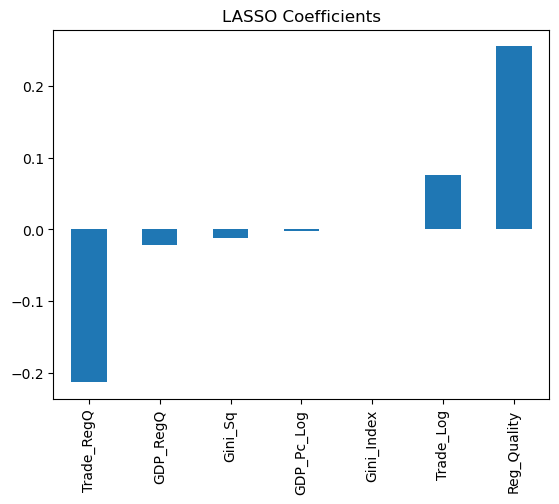

In [47]:
## Testing for Robustness using LASSO

# Demeaning dependent vector to remove country FE
y_dm = (y -
        y.groupby(level=0).transform('mean') -
        y.groupby(level=1).transform('mean') +
        y.mean())

# Copying X design matrix
X_dm = X.copy()

# Performing demeaning transformations
for col in X_dm.columns:
    X_dm[col] = (X_dm[col] -
                 X_dm[col].groupby(level=0).transform('mean') -
                 X_dm[col].groupby(level=1).transform('mean') +
                 X_dm[col].mean())

# Dropping intercept column
X_dm = X_dm.drop(columns=['Intercept'])
# Standardising X
X_std = (X_dm - X_dm.mean()) / X_dm.std()

# Checking for empty rows
X_std.isna().sum()

# Running LASSO cross-validation to find penalty
Lasso_cv = LassoCV(cv=5, random_state=0)
estimate_cv = Lasso_cv.fit(X_std, y_dm)

# Defining penalty variable
penalty = estimate_cv.alpha_
print(f"The penalty selected through cross-validation is {penalty}\n")

# Running Lasso model
Lasso_model = linear_model.Lasso(alpha=penalty)
estimate_lasso = Lasso_model.fit(X_std, y_dm)

# Extracting coefficient series
coefs = pd.Series(estimate_lasso.coef_, index=X_dm.columns)
print(coefs, "\n")

# Plotting coefficients
coefs.sort_values().plot(kind='bar')
plt.title("LASSO Coefficients")
plt.show()

The fact that LASSO dropped the Gini term but not its quadratic transformation tells us a lot about the nature of the relationship between Gini and FDI inflows. The level effect of inequality on FDI inflows has no explanatory power, it is only the quadratic distribution of Gini that explains some of the variation in FDI inflows.

We now run the regression again without the Gini Index variable:

In [48]:
# Defining post-Lasso dataframe by dropping Gini
X_post = X.drop(columns=['Gini_Index'])

# Running Panel OLS
model_2b = PanelOLS(y, X_post, entity_effects=True, time_effects=True, drop_absorbed=True)
estimate_2b = model_2b.fit(cov_type='clustered', cluster_entity=False)


# Comparing the two results
comparative_table = compare({
    'Pre-LASSO OLS' : estimate_2,
    'Post-LASSO OLS' : estimate_2b
})
print(comparative_table)

                  Model Comparison                  
                        Pre-LASSO OLS Post-LASSO OLS
----------------------------------------------------
Dep. Variable                 FDI_Log        FDI_Log
Estimator                    PanelOLS       PanelOLS
No. Observations                 3581           3581
Cov. Est.                   Clustered      Clustered
R-squared                      0.0159         0.0154
R-Squared (Within)             0.0241         0.0233
R-Squared (Between)            0.0832         0.0909
R-Squared (Overall)            0.0448         0.0457
F-statistic                    7.7780         8.8090
P-value (F-stat)               0.0000         0.0000
=====================     ===========    ===========
Intercept                     -1.3160         0.9389
                            (-0.4891)       (0.7180)
Trade_Log                      0.4006         0.3971
                             (2.6679)       (2.6575)
GDP_Pc_Log                    -0.0691        -

# Interpretation of LASSO selection model results

## 3. Does higher spending on education **within a country** translate to increased growth?
We define:
$$
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \beta_0
+ \beta_1 \,\text{Educ\_Log}_{it}
+ \beta_2 \,\text{Trade\_Log}_{it}
+ \beta_3 \,\text{Gini\_Index}_{it}
+ \beta_4 \,\text{Gini\_sq}_{it}
+ \beta_5 \,\text{Govt\_Effectiveness}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
+ \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$

We aim to estimate the **within** country effect of education spending on growth. Our dependent variable is GDP Growth and our main explanatory variable is the log of Education Spending. Country and time fixed effects will again be used to control for time-invariant differences between countries and global trends.

In [49]:
# Question 3

# Setting up formula
formula_3 = (""
           "GDP_Growth ~ Educ_Log + Trade_Log + "
           "Gini_Index + Gini_Sq + Govt_Effectiveness + "
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_3 = ["GDP_Growth", 'Educ_Log', 'Trade_Log',
          'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness',
          'Educ_Govt_Eff']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q3 = wb_imputed.dropna(subset=vars_3)

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

# Rows after
after = wb_q3.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_3, data=wb_q3, return_type='dataframe')

# Defining OLS model
model_3 = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)

# Estimating
estimate_3 = model_3.fit(cov_type='clustered', cluster_entity=False)

print(estimate_3.summary)

stat_significance(estimate_3)

We dropped 21.66% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:             GDP_Growth   R-squared:                        0.0470
Estimator:                   PanelOLS   R-squared (Between):             -2.5751
No. Observations:                3537   R-squared (Within):               0.0470
Date:                Wed, Nov 26 2025   R-squared (Overall):             -0.3595
Time:                        13:51:40   Log-likelihood                 -1.04e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.656
Entities:                         170   P-value                           0.0000
Avg Obs:                       20.806   Distribution:                  F(6,3361)
Min Obs:                       9.0000                                           
Max Obs:                       21.000   F-statistic (robust):             16.487
     

# 3a. Is there endogeneity and how do we address it?

GDP Growth and Education Expenditure exhibit simultaneity since they have a two-way casual effect. This biases the estimates and makes the OLS estimators inconsistent. A relevant and valid instrument can mitigate this. A candidate instrument is the lag of Education Expenditure. We assume education expenditure in the previous year will not affect the economic growth of this year. We also expect that the expenditure on Education this year will be related to that of last year's.

We set the instrument for Education Expenditure as:
$Z_{1, it} = \text{Educ\_Log}_{i(t-1)}$

Its first stage equation:
$\begin{aligned}
\text{Educ\_Log}_{it}
&= \pi_0
+ \pi_1 \,\text{Educ\_Log}_{i,t-1}
+ \boldsymbol{\pi}_2^{\prime} \mathbf{C}_{it}
+ \alpha_i + \lambda_t + u_{it},
\end{aligned}\\[1em]$

$\boldsymbol{\pi}_2^{\prime} \mathbf{C}_{it} = \text{Vector of controls with vector of coefficients}\\[1em]$

And the instrument for the interaction term as:
$
\left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
= \theta_0
+ \theta_1 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \boldsymbol{\theta}_2^{\prime} \mathbf{C}_{it}
+ \alpha_i + \lambda_t + v_{it}\\[1em]
$

$\boldsymbol{\theta}_2^{\prime} \mathbf{C}_{it} = \text{Vector of controls with vector of coefficients}\\[1em]$

In [50]:
from statsmodels.api import add_constant
# Recreating dataframe for replicability
wb_q3 = wb_imputed.copy()
wb_q3 = wb_q3.dropna(subset=vars_3)

#Reseting index
wb_q3.reset_index(inplace=True, drop=True)
## Creating lagged education variable

# Grouping by country code and education expenditure and shifting up by 1 (if for replicability)
wb_q3['Educ_Lag1'] = wb_q3.groupby('iso3')['Educ_Log'].shift(1)

# Checking for missing values
print(wb_q3['Educ_Lag1'].isna().sum())
# IV2SLS handles missing values, no need to do anything

# Creating lagged interaction
wb_q3['Educ_Govt_Lag'] = wb_q3['Educ_Lag1'] * wb_q3['Govt_Effectiveness']

## Defining model specifications

# Adding constant
wb_q3 = add_constant(wb_q3, has_constant='add')

# Controls
controls = wb_q3[['const', 'Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness']]

# Endogenous variables
endog = wb_q3[['Educ_Log', 'Educ_Govt_Eff']]

#Instruments
instruments = wb_q3[['Educ_Lag1', 'Educ_Govt_Lag']]

# IV model
model_IV = IV2SLS(wb_q3['GDP_Growth'],
                  controls,
                  endog,
                  instruments)

# Fitting model
estimate_IV = model_IV.fit(cov_type='robust')

170


C:\Users\andre\anaconda3\Lib\site-packages\linearmodels\iv\model.py:560: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


# 3b. What is the interpretation of the first-stage 2SLS result?

In [51]:
# First stage result
print(estimate_IV.first_stage.summary)

           First Stage Estimation Results           
                              Educ_Log Educ_Govt_Eff
----------------------------------------------------
R-squared                       0.9845        0.9980
Partial R-squared               0.9829        0.9976
Shea's R-squared                0.8864        0.8997
Partial F-statistic          3.265e+05     4.833e+05
P-value (Partial F-stat)        0.0000        0.0000
Partial F-stat Distn           chi2(2)       chi2(2)
========================== ===========   ===========
const                           0.3096        0.0090
                              (3.1414)      (0.1936)
Trade_Log                      -0.0155       -0.0013
                             (-3.4629)     (-0.3274)
Gini_Index                     -0.0073       -0.0009
                             (-1.5931)     (-0.5293)
Gini_Sq                      8.512e-05     9.677e-06
                              (1.4187)      (0.4448)
Govt_Effectiveness              0.0449       -

We can see that the partial F-statistics are very large, meaning the instruments are very strong.

# 3c. What is the interpretation of the second-stage 2SLS result?

In [52]:
# 2nd stage summary
print(estimate_IV.summary)

# Statistical significance of each coefficient
stat_significance(estimate_IV)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             GDP_Growth   R-squared:                      0.0285
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0267
No. Observations:                3367   F-statistic:                    106.65
Date:                Wed, Nov 26 2025   P-value (F-stat)                0.0000
Time:                        13:51:44   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                 -6.4910     2.2015    -2.9485     0.0032     -10.806     -2.1762
Trade_Log           

# Conclusion

<!-- EXCLUDE -->
# References:
The World Bank (2025) Poverty and Inequality – World Development Indicators. Available at: https://datatopics.worldbank.org/world-development-indicators/themes/poverty-and-inequality.html
 (Accessed: 9 November 2025).

The World Bank (2025) People – World Development Indicators. Available at: https://datatopics.worldbank.org/world-development-indicators/themes/people.html
 (Accessed: 9 November 2025).

https://data.worldbank.org/indicator/

World Bank (2024) Worldwide Governance Indicators: Documentation. Available at: https://www.worldbank.org/en/publication/worldwide-governance-indicators/documentation
 (Accessed: 14 November 2025).

World Bank (2025) Regulatory Quality. [online]. Washington, DC: World Bank. Available from: https://www.worldbank.org/content/dam/sites/govindicators/doc/rq.pdf
 [Accessed 26 November 2025].

World Bank (2024) Government Effectiveness: Representative Sources. Available at: https://www.worldbank.org/content/dam/sites/govindicators/doc/ge.pdf
 (Accessed: 14 November 2025).

World Bank (2025) Foreign direct investment, net inflows (% of GDP) [Indicator: BX.KLT.DINV.WD.GD.ZS]. World Development Indicators. Available at: https://data.worldbank.org/indicator/BX.KLT.DINV.WD.GD.ZS
 (Accessed: 14 November 2025).

Solt, Frederick, 2019, "The Standardized World Income Inequality Database, Versions 8-9", https://doi.org/10.7910/DVN/LM4OWF, Harvard Dataverse, V14; x_swiid9_8.zip [fileName]

Wooldridge, J.M. (2015) Introductory Econometrics: A Modern Approach. 6th edn. Boston, MA: Cengage Learning.

Kennedy, P. (2008) A Guide to Econometrics. 6th edn. Malden, MA: Blackwell Publishing.

Banerjee, A. and Duflo, E. (2003) ‘Inequality and growth: what can the data say?’, Journal of Economic Growth, 8(3), pp. 267–299.

Bellemare, M.F. and Wichman, C.J. (2020) ‘Elasticities and the inverse hyperbolic sine transformation’, Oxford Bulletin of Economics and Statistics, 82(1), pp. 50–61. doi: 10.1111/obes.12325.

https://github.com/pycountry


https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025

https://worldpopulationreview.com/country-rankings/gdp-per-capita-by-country

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/LIE?zoom=LIE&highlight=LIE



https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes


In [58]:
import json

# 1. Set your notebook file name here
notebook = "data_exploration.ipynb"  # <- change this!

# 2. Load the notebook
with open(notebook, "r", encoding="utf-8") as f:
    nb = json.load(f)

# 3. Collect all markdown cells
md_cells = []
for cell in nb["cells"]:
    if cell.get("cell_type") == "markdown":
        text = "".join(cell.get("source", []))
        md_cells.append(text.strip())

# 4. Join them with a separator (optional)
full_markdown = "\n\n---\n\n".join(md_cells)

# 5. Save to a markdown file
output_file = "notebook_markdown_export.md"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(full_markdown)

output_file


'notebook_markdown_export.md'